In [277]:
import os
import math
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import matplotlib as mpl

# ДОМЕН И СЕТКА
X_MIN, X_MAX = 0.0, 2.0 * math.pi   # [0, 2π]
Y_MIN, Y_MAX = 0.0, 2.0 * math.pi   # [0, 2π]
T_MIN, T_MAX = 0.0, 1.0             # безразмерное время

N_X = 32                            # число узлов по x
N_Y = 32                            # число узлов по y
N_T = 101                           # число слоёв по времени

# ПАРАМЕТРЫ МОДЕЛИ ТЕЙЛОРА–ГРИНА (БЕЗРАЗМЕРНЫЕ)
RE = 6.0                            # число Рейнольдса
P0 = 0.0                            # средний уровень давления

DTYPE = np.float64

OUTPUT_DIR = ""                # путь для сохранения
OUTPUT_BASENAME = "E_clean_TG"      # базовое имя файла без расширения
OUTPUT_FORMAT = "npz"               # формат сохранения: npz

In [286]:
# Общие утилиты

def ensure_dir(path: str) -> None:
    """Создаёт каталог при необходимости"""
    if path and not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

def make_1d_grid(a: float, b: float, n: int, endpoint: bool = False, dtype=DTYPE) -> np.ndarray:
    """
    Равномерная сетка [a, b) при endpoint=False (для периодичности).
    При endpoint=True получится [a, b].
    """
    return np.linspace(a, b, num=n, endpoint=endpoint, dtype=dtype)

def save_e_clean_npz(
    out_dir: str,
    basename: str,
    x: np.ndarray,
    y: np.ndarray,
    t: np.ndarray,
    U: np.ndarray,
    V: np.ndarray,
    P: np.ndarray,
    meta: dict
) -> str:
    """Сохраняет данные в .npz и возвращает путь к файлу."""
    ensure_dir(out_dir)
    fname = f"{basename}_Re{meta['RE']}_NX{meta['N_X']}_NY{meta['N_Y']}_NT{meta['N_T']}.{OUTPUT_FORMAT}"
    fpath = os.path.join(out_dir, fname)
    if OUTPUT_FORMAT == "npz":
        np.savez_compressed(
            fpath,
            x=x, y=y, t=t,
            U=U, V=V
        )
    return fpath


# Мат модель
def taylor_green_vortex(x: np.ndarray, y: np.ndarray, t: float,
                           re: float, p0: float, dtype=DTYPE):
    """
    Вычисляет (u, v, p) на декартовой сетке (X,Y) для момента времени t.
    x, y — одномерные массивы узлов; возвращаемые тензоры имеют форму (N_y, N_x).
    """
    # Сетки
    X, Y = np.meshgrid(x, y, indexing="xy")
    # Множители
    e1 = math.exp(-2.0 * t / re)    # для u, v, ω
    e2 = math.exp(-4.0 * t / re)    # для p
    cos_x = np.cos(X, dtype=dtype)
    sin_x = np.sin(X, dtype=dtype)
    cos_y = np.cos(Y, dtype=dtype)
    sin_y = np.sin(Y, dtype=dtype)
    u = (cos_x * sin_y * e1 ).astype(dtype, copy=False)
    v = (-sin_x * cos_y * e1 ).astype(dtype, copy=False)
    p =  (p0+(np.cos(2.0*X, dtype=dtype)+np.cos(2.0*Y, dtype=dtype))/(-4.0)*e2).astype(dtype, copy=False)
    #psi = (-cos_x * cos_y * e1).astype(dtype, copy=False)
    return u, v, p


In [283]:
# Сетки
x = make_1d_grid(X_MIN, X_MAX, N_X, endpoint=False, dtype=DTYPE)
y = make_1d_grid(Y_MIN, Y_MAX, N_Y, endpoint=False, dtype=DTYPE)
t = make_1d_grid(T_MIN, T_MAX, N_T, endpoint=True, dtype=DTYPE)
# Контейнеры под поля: форма (N_T, N_Y, N_X)
U = np.empty((N_T, N_Y, N_X), dtype=DTYPE)
V = np.empty((N_T, N_Y, N_X), dtype=DTYPE)
P = np.empty((N_T, N_Y, N_X), dtype=DTYPE)
# Заполнение по времени
for n in range(N_T):
    u_n, v_n, p_n = taylor_green_vortex(
        x=x, y=y, t=float(t[n]),
        re=RE, p0=P0, dtype=DTYPE
    )
    U[n, :, :] = u_n
    V[n, :, :] = v_n
    P[n, :, :] = p_n


In [287]:
#  Метаданные и сохранение
META = dict(
    MODEL="Taylor-Green vortex (2D, incompressible)",
    DOMAIN=[float(X_MIN), float(X_MAX), float(Y_MIN), float(Y_MAX)],
    TIME=[float(T_MIN), float(T_MAX)],
    N_X=int(N_X), N_Y=int(N_Y), N_T=int(N_T),
    RE=float(RE), P0=float(P0),
    DTYPE=str(np.dtype(DTYPE)),
    NOTES="Clean (noise-free) reference dataset E_clean"
)
OUTPUT_PATH = save_e_clean_npz(
    out_dir=OUTPUT_DIR,
    basename=OUTPUT_BASENAME,
    x=x, y=y, t=t, U=U, V=V, 
    P=P, meta=META
)

In [248]:
def read_e_clean_npz(fpath: str):
    with np.load(fpath, allow_pickle=True) as z:
        x = z["x"]; y = z["y"]; t = z["t"]
        U = z["U"]; V = z["V"]; P = z["P"]
    return x, y, t, U, V, P


def visualize_velocity_directions_ru(npz_path: str,
                                     t_index: int,
                                     density: float = 1.6,
                                     figsize: tuple[int, int] = (6, 6),
                                     cmap: str = "RdBu_r"):
    x, y, t, U, V, P = read_e_clean_npz(npz_path)
    p_abs_global = float(np.abs(P).max())
    # максимум скорости по всем t
    speed_global_max = float(np.sqrt(U**2 + V**2).max())
    if speed_global_max <= 0:
        speed_global_max = 1.0
    # выбор момента времени
    idx = t_index
    u = U[idx]; v = V[idx]; p = P[idx]
    speed = np.hypot(u, v)
    norm = mpl.colors.TwoSlopeNorm(vmin=-p_abs_global, vcenter=0.0, vmax=p_abs_global)
    lw = 0.6 + (2.0 - 0.6) * (speed / speed_global_max)
    X, Y = np.meshgrid(x, y, indexing="xy")
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    # давление p
    ax.pcolormesh(X, Y, p, shading="nearest", cmap=cmap, norm=norm,
                  edgecolors="none", linewidth=0, antialiased=False)
    # линии тока
    ax.streamplot(x, y, u, v, density=density, color="k", linewidth=lw)
    # оформление
    ax.set_xlim(x.min(), x.max()); ax.set_ylim(y.min(), y.max())
    for sp in ax.spines.values(): sp.set_visible(False)
    ax.tick_params(length=0)
    pi = np.pi
    ticks  = [pi/2, pi, 3*pi/2, 2*pi]
    labels = [r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    ax.set_xticks(ticks); ax.set_xticklabels(labels)
    ax.set_yticks(ticks); ax.set_yticklabels(labels)
    ax.tick_params(labelsize=11, length=0)
    ax.annotate(r"$0$", xy=(x.min(), y.min()), xycoords="data",
                xytext=(-6, -6), textcoords="offset points",
                ha="right", va="top", fontsize=11, clip_on=False)
    ax.grid(False)
    plt.show()
    return plt


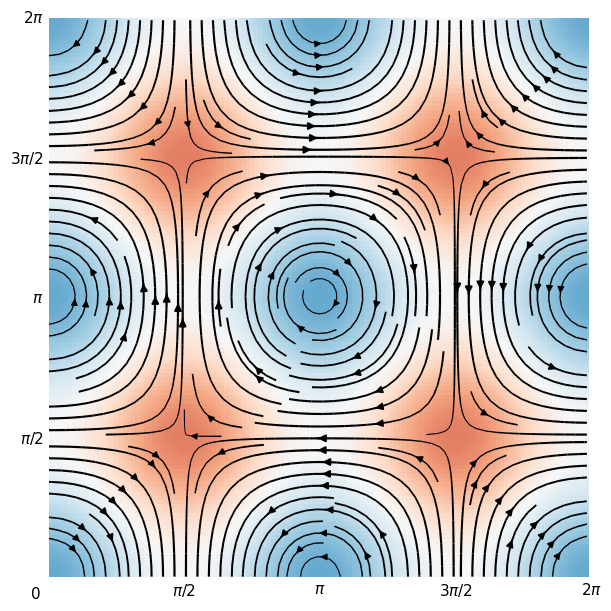

In [227]:
_ = visualize_velocity_directions_ru(OUTPUT_PATH, t_index=100)

In [249]:
def make_gif_from_visualizer(npz_path: str, fps: float, t_max: int) -> str:
    res = read_e_clean_npz(npz_path)
    t = res[2]                      # x, y, t, ...
    T = min(int(t_max), len(t))
    frames = []
    out_dir  = os.path.dirname(npz_path)
    out_name = os.path.splitext(os.path.basename(npz_path))[0] + "_anim.gif"
    out_path = os.path.join(out_dir, out_name)
    _orig_show = plt.show
    try:
        plt.ioff()
        plt.show = lambda *a, **k: None
        for idx in range(T):
            visualize_velocity_directions_ru(npz_path, t_index=idx)
            fig = plt.gcf()
            buf = io.BytesIO()
            # фиксированный кадр без «подрезаний», чтобы не было дрожания
            fig.savefig(buf, format="png", dpi=150)
            buf.seek(0)
            frames.append(imageio.imread(buf))
            plt.close(fig)
    finally:
        plt.show = _orig_show
        plt.ion()
    imageio.mimsave(out_path, frames, duration=1.0/float(fps))
    return out_path


In [259]:
gif_path = make_gif_from_visualizer("E_clean_TG_Re6.0_NX128_NY128_NT101.npz", fps=1, t_max=N_T)
print("GIF:", gif_path)

GIF: E_clean_TG_Re6.0_NX128_NY128_NT101_anim.gif


In [260]:
gif_path = make_gif_from_visualizer("E_clean_TG_Re6.0_NX64_NY64_NT101.npz", fps=1, t_max=N_T)
print("GIF:", gif_path)

GIF: E_clean_TG_Re6.0_NX64_NY64_NT101_anim.gif


In [261]:
gif_path = make_gif_from_visualizer("E_clean_TG_Re6.0_NX32_NY32_NT101.npz", fps=1, t_max=N_T)
print("GIF:", gif_path)

GIF: E_clean_TG_Re6.0_NX32_NY32_NT101_anim.gif


In [241]:
def make_noisy_datasets_by_snr(OUTPUT_PATH: str, SNR_values, *,
                               x: np.ndarray, y: np.ndarray, t: np.ndarray,
                               U_clean: np.ndarray, V_clean: np.ndarray, P: np.ndarray,
                               basename: str = "eTG", seed: int | None = None, dtype=DTYPE
                               ) -> dict[float, str]:
    ensure_dir(OUTPUT_PATH)
    # нормализуем список SNR
    snr_list = [float(SNR_values)] if np.isscalar(SNR_values) \
               else [float(s) for s in SNR_values]
    # мощность сигналов на всей выборке
    P_u = float(np.mean(np.square(U_clean, dtype=dtype)))
    P_v = float(np.mean(np.square(V_clean, dtype=dtype)))
    rng = np.random.default_rng(seed)
    out_paths: dict[float, str] = {}
    for snr_db in snr_list:
        # ст. отклонения шума из SNR
        sigma_u = math.sqrt(P_u / (10.0 ** (snr_db / 10.0)))
        sigma_v = math.sqrt(P_v / (10.0 ** (snr_db / 10.0)))
        # независимый шум
        eps_u = rng.normal(0.0, sigma_u, size=U_clean.shape).astype(dtype, copy=False)
        eps_v = rng.normal(0.0, sigma_v, size=V_clean.shape).astype(dtype, copy=False)
        U_noisy = (U_clean + eps_u).astype(dtype, copy=False)
        V_noisy = (V_clean + eps_v).astype(dtype, copy=False)
        nx, ny, nt = len(x), len(y), len(t)
        snr_tag = f"SNR{int(round(snr_db))}" if abs(snr_db - round(snr_db)) < 1e-9 else f"SNR{snr_db:g}"
        fname = f"{basename}_NX{nx}_NY{ny}_NT{nt}_{snr_tag}.{OUTPUT_FORMAT}"
        fpath = os.path.join(OUTPUT_PATH, fname)
        if OUTPUT_FORMAT == "npz":
            np.savez_compressed(fpath, x=x, y=y, t=t, U=U_noisy, V=V_noisy, P=P)
        else:
            raise ValueError(f"Unsupported OUTPUT_FORMAT={OUTPUT_FORMAT!r}")
        out_paths[snr_db] = fpath
    return out_paths


In [250]:
paths = make_noisy_datasets_by_snr(
    OUTPUT_PATH="./out1",
    SNR_values=[10, 20, 30],
    x=x, y=y, t=t,
    U_clean=U, V_clean=V, P=P,
    basename="eTG",
    seed=42, dtype=DTYPE
)

In [ ]:
paths = make_noisy_datasets_by_snr(
    OUTPUT_PATH="./out2",
    SNR_values=[10, 20, 30],
    x=x, y=y, t=t,
    U_clean=U, V_clean=V, P=P,
    basename="eTG",
    seed=42, dtype=DTYPE
)

In [258]:
paths = make_noisy_datasets_by_snr(
    OUTPUT_PATH="./out3",
    SNR_values=[10, 20, 30],
    x=x, y=y, t=t,
    U_clean=U, V_clean=V, P=P,
    basename="eTG",
    seed=42, dtype=DTYPE
)

In [262]:
gif_path = make_gif_from_visualizer("./out1/eTG_NX128_NY128_NT101_SNR10.npz", fps=1, t_max=N_T)
print("GIF:", gif_path)

GIF: ./out1\eTG_NX128_NY128_NT101_SNR10_anim.gif


In [263]:
gif_path = make_gif_from_visualizer("./out1/eTG_NX128_NY128_NT101_SNR20.npz", fps=1, t_max=N_T)
print("GIF:", gif_path)

GIF: ./out1\eTG_NX128_NY128_NT101_SNR20_anim.gif


In [264]:
gif_path = make_gif_from_visualizer("./out1/eTG_NX128_NY128_NT101_SNR30.npz", fps=1, t_max=N_T)
print("GIF:", gif_path)

GIF: ./out1\eTG_NX128_NY128_NT101_SNR30_anim.gif


In [271]:
gif_path = make_gif_from_visualizer("./out2/eTG_NX64_NY64_NT101_SNR10.npz", fps=1, t_max=N_T)
print("GIF:", gif_path)

GIF: ./out2\eTG_NX64_NY64_NT101_SNR10_anim.gif


In [272]:
gif_path = make_gif_from_visualizer("./out2/eTG_NX64_NY64_NT101_SNR20.npz", fps=1, t_max=N_T)
print("GIF:", gif_path)

GIF: ./out2\eTG_NX64_NY64_NT101_SNR20_anim.gif


In [273]:
gif_path = make_gif_from_visualizer("./out2/eTG_NX64_NY64_NT101_SNR30.npz", fps=1, t_max=N_T)
print("GIF:", gif_path)

GIF: ./out2\eTG_NX64_NY64_NT101_SNR30_anim.gif


In [274]:
gif_path = make_gif_from_visualizer("./out3/eTG_NX32_NY32_NT101_SNR10.npz", fps=1, t_max=N_T)
print("GIF:", gif_path)

GIF: ./out3\eTG_NX32_NY32_NT101_SNR10_anim.gif


In [275]:
gif_path = make_gif_from_visualizer("./out3/eTG_NX32_NY32_NT101_SNR20.npz", fps=1, t_max=N_T)
print("GIF:", gif_path)

GIF: ./out3\eTG_NX32_NY32_NT101_SNR20_anim.gif


In [276]:
gif_path = make_gif_from_visualizer("./out3/eTG_NX32_NY32_NT101_SNR30.npz", fps=1, t_max=N_T)
print("GIF:", gif_path)

GIF: ./out3\eTG_NX32_NY32_NT101_SNR30_anim.gif
